In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.load("DK_time_series_for_new_loss.npy")
data = data[0] + data[3]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [4]:
from IPython.display import clear_output

In [11]:
def Frechet_loss(y_pred, y_true, alpha=10, s=1.7):
    u = torch.abs(y_pred - y_true)
    #u[0] = max(u[0], -1)
    #print(u)
    K = alpha/s*((u+s*(alpha/(1+alpha))**(1/alpha))/s)**(-1-alpha)
    return torch.sum(-torch.log(K) + ((u+s*(alpha/(1+alpha))**(1/alpha))/s)**-alpha)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [7]:
from torch.utils.data import DataLoader

In [8]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [9]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

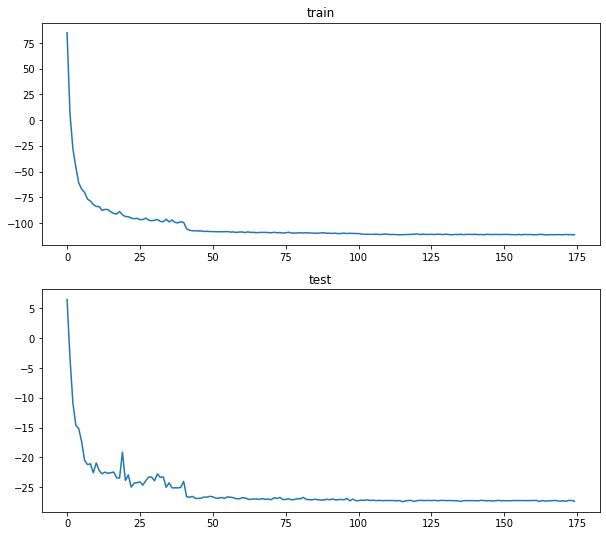

Epoch[175/175] | loss train:-111.548081, test:-27.377789


In [12]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

# define optimizer, scheduler and loss function
criterion = Frechet_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

In [13]:
def ShowPredict(model, train, test, mean=None, std=None):
    if mean is None:
        mean = train.mean()
    if std is None:
        std = train.std()
    train = (train - mean)/std
    train = torch.FloatTensor(train).view(-1)
        
    test = (test - mean)/std
    test = torch.FloatTensor(test).view(-1)
    
    train_inout_seq = create_inout_sequences(train, train_window)
    test_inout_seq = create_inout_sequences(test, train_window)
    train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

    model.eval()

    # predict on the training data, to see how well the model managed to learn and memorize

    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    # predict on the test data

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(3, 2, 1)
    ax_1.set_title("Bit of predicted train with true train")  
    ax_1.plot(train[220:340], label='true')
    ax_1.plot(predicted_train[200:320], label='predicted')
    ax_1.legend()
    
    ax_2 = fig.add_subplot(3, 2, 2)
    ax_2.set_title("Bit of predicted test with true test") 
    ax_2.plot(test[220:340], label='true')
    ax_2.plot(predicted_val[200:320], label='predicted')
    ax_2.legend()

    ax_3 = fig.add_subplot(3, 2, 3)
    ax_3.set_title("Predicted train") 
    ax_3.plot(predicted_train)

    ax_4 = fig.add_subplot(3, 2, 4)
    ax_4.set_title("Predicted test") 
    ax_4.plot(predicted_val)
    
    ax_5 = fig.add_subplot(3, 2, 6)
    ax_5.set_title("Test") 
    ax_5.plot(test)
    
    ax_6 = fig.add_subplot(3, 2, 5)
    ax_6.set_title("Train") 
    ax_6.plot(train)
    
    train_right_part = (len(train)- 20)%64
    test_right_part = (len(test)- 20)%64

    train_rmse = ((np.array(predicted_train) - np.array(train[20:-train_right_part]))**2).mean()**0.5
    test_rmse = ((np.array(predicted_val) - np.array(test[20:-test_right_part]))**2).mean()**0.5

    print("Train rmse:", train_rmse)
    print("Test rmse:", test_rmse)
    
    plt.show()

Train rmse: 0.06487126643548947
Test rmse: 0.12199602666146105


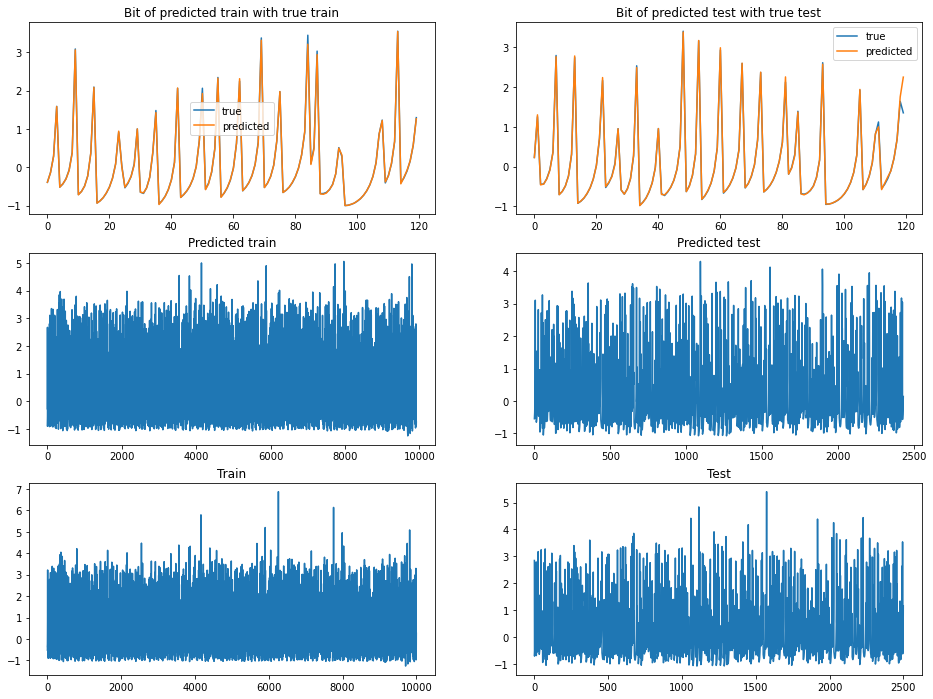

In [15]:
ShowPredict(model, train, test, mean=mean, std=std)

In [16]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

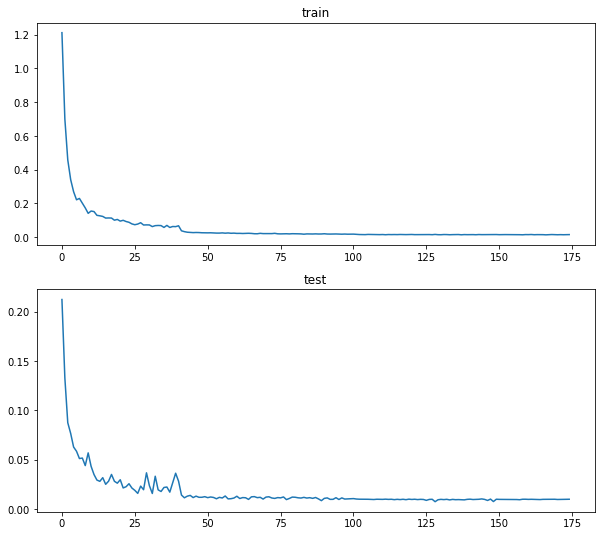

Epoch[175/175] | loss train:0.015195, test:0.010027


In [17]:
# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

Train rmse: 0.04810776291631057
Test rmse: 0.1288796861003022


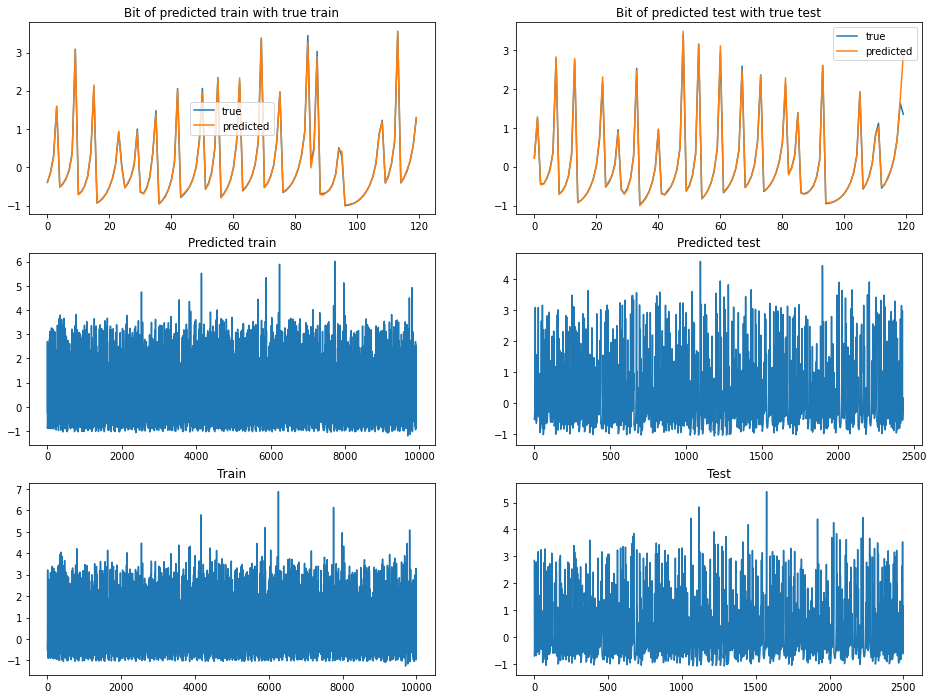

In [18]:
ShowPredict(model, train, test, mean=mean, std=std)